In [14]:
import sqlite3
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import numpy as np

from statistics import mode
import os
from dotenv import load_dotenv

load_dotenv()
DB_PATH = os.getenv("DATABASE_URL", "sqlite.db")

import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# The model

In [15]:
#embedder_model = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
#embedder_model='sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
embedder_model="hiiamsid/sentence_similarity_spanish_es"
embedder = SentenceTransformer(embedder_model)

2025-04-30 13:04:32,560 - INFO - Use pytorch device_name: mps
2025-04-30 13:04:32,561 - INFO - Load pretrained SentenceTransformer: hiiamsid/sentence_similarity_spanish_es


# Some functions

In [16]:

def optimalK(data, nrefs=3, maxClusters=15):
    """
        Gap Statistic for K means
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = []

    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop

        for i in range(nrefs):
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)

            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)

            refDisp = km.inertia_
            refDisps[i] = refDisp

            # Fit cluster to original data and create dispersion
            km = KMeans(k)
            km.fit(data)

            origDisp = km.inertia_# Calculate gap statistic
            gap = np.log(np.mean(refDisps)) - np.log(origDisp)# Assign this loop's gap statistic to gaps
            gaps[gap_index] = gap

            resultsdf.append([k,gap])

            df_extended = pd.DataFrame(resultsdf, columns=['clusterCount', 'gap'])

    return (gaps.argmax() + 1, df_extended)


def fetch_questions(table_name, rei_id, period):
    query = f"""
        SELECT question, coalesce(g.id, 'Desconocido') as group_id, coalesce(u.name, 'Desconocido') as lider_name
        FROM {table_name} q
        LEFT JOIN "class" c ON c.id = q.class_id
        LEFT JOIN "group" g ON g.id = q.group_id
        LEFT JOIN "user" u ON u.id = g.lider_id
        WHERE c.id = ? AND c.recorrido_id = ?;
    """

    with sqlite3.connect(DB_PATH) as con:
        cursor = con.cursor()
        cursor.execute(query, (period, rei_id))
        result = cursor.fetchall()
        logging.debug(f"Fetched {len(result)} questions from {table_name} for REI ID: {rei_id} and period: {period}")
        return result


def preprocess_questions(questions):
    if not questions:
        return pd.DataFrame(columns=["pregunta", "grupo", "lider_name", "votos"])

    dfcorpus = pd.DataFrame(questions)
    dfcorpus = dfcorpus.rename(columns={0: "pregunta", 1: "grupo", 2: "lider_name"})

    dfcorpus["votos"] = 1
    corpus = dfcorpus["pregunta"].tolist()
    corpus_embeddings = embedder.encode(corpus)

    # Compute cosine similarities
    similarities = embedder.similarity(corpus_embeddings, corpus_embeddings)
    to_remove = []

    for idx_i, sentence1 in enumerate(corpus):
        count_matches = 0
        match_groups = dfcorpus['grupo'].iloc[idx_i]

        for idx_j, sentence2 in enumerate(corpus):
            sim = similarities[idx_i][idx_j]

            if (sim > 0.9) and (idx_i != idx_j):
                count_matches += 1
                gxj = dfcorpus['grupo'].iloc[idx_j]
                match_groups = match_groups + "," + gxj

                if (idx_j>idx_i):
                    to_remove.append(idx_j)

        dfcorpus.iloc[idx_i, dfcorpus.columns.get_loc('votos')] = count_matches + 1
        dfcorpus.iloc[idx_i, dfcorpus.columns.get_loc('grupo')] = str(match_groups)

    if len(to_remove)>0:
        rm_indexes = np.array(to_remove)
        dfcorpus = dfcorpus.drop(dfcorpus.index[rm_indexes])

    return dfcorpus

def select_optimal_k(embeddings, max_k=15):
    """
        Selecciona el número óptimo de clusters utilizando el método del codo y la puntuación de Silhouette.
    """
    best_k = 2
    best_score = -1
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
        score = silhouette_score(embeddings, kmeans.labels_, metric='cosine')
        if score > best_score:
            best_k = k
            best_score = score
    if best_k == 1:
        logging.warning("El número óptimo de clusters es 1. Esto puede indicar que los datos no tienen suficiente variación.")
    logging.info(f"Optimal k: {best_k} (Silhouette Score: {best_score:.3f})")
    return max(best_k, 2)  # Asegurarse de que k sea al menos 2

def merge_similar_clusters(df, embeddings, threshold=0.85):
    # Calcular centroides de cada cluster
    centroids = []
    clusters = df['cluster'].unique()
    for cluster in clusters:
        cluster_embeddings = embeddings[df['cluster'] == cluster]
        centroids.append(np.mean(cluster_embeddings, axis=0))
    
    # Matriz de similitud entre centroides
    sim_matrix = cosine_similarity(centroids)
    
    # Fusionar clusters similares
    clusters_merged = {}
    new_cluster_id = 0
    for i, cluster in enumerate(clusters):
        if cluster not in clusters_merged:
            clusters_merged[cluster] = new_cluster_id
            for j in range(i + 1, len(clusters)):
                if sim_matrix[i][j] > threshold:
                    clusters_merged[clusters[j]] = new_cluster_id
            new_cluster_id += 1
    
    # Aplicar fusión al DataFrame
    df['cluster'] = df['cluster'].map(clusters_merged)
    return df

def plot_clusters(embeddings, cluster_assignment):
    reducer = UMAP(n_components=2, metric='cosine', random_state=42)
    reduced_embeds = reducer.fit_transform(embeddings)
    
    plt.scatter(reduced_embeds[:, 0], reduced_embeds[:, 1], 
                c=cluster_assignment, cmap='Spectral', s=10)
    plt.title("Clusters después de UMAP")
    plt.colorbar()
    plt.show()

# Kmeans

In [17]:
num_clusters = 0
clustering_model = None

def train_cluster_model(corpus_embeddings):
    global num_clusters
    global clustering_model
    
    if not num_clusters:
        if len(corpus_embeddings)<15:
            maxC=len(corpus_embeddings)
        else:
            maxC=15

        scores = []
        for i in range(0,5):
            score_g, df = optimalK(corpus_embeddings, maxClusters=maxC)
            scores.append(score_g)

        score_g = mode(scores)
        num_clusters = score_g

    clustering_model = KMeans(n_clusters=num_clusters, random_state=0)
    clustering_model.fit(corpus_embeddings)

def clusterize_dx_questions(rei_id, period):
        questions = fetch_questions("dx_question", rei_id, period)
        dfcorpus = preprocess_questions(questions)
        
        if dfcorpus.empty:
            dfcorpus['cluster'] = None
            return dfcorpus

        corpus = dfcorpus["pregunta"].tolist()
        corpus_embeddings = embedder.encode(corpus)

        # Normalización de los embeddings
        #scaler = StandardScaler()
        #normalized_embeddings = scaler.fit_transform(corpus_embeddings)

        # Reducir dimensionalidad
        #pca = PCA(n_components=50)
        #reduced_embeddings = pca.fit_transform(normalized_embeddings)
        #reducer = UMAP(n_components=2, min_dist=0.1, metric='cosine')  # min_dist bajo para mayor separación
        #reduced_embeddings = reducer.fit_transform(normalized_embeddings)

        # 1. Clustering con KMeans
        train_cluster_model(corpus_embeddings)

        cluster_assignment = clustering_model.labels_
        cluster_assignment = [x + 1 for x in cluster_assignment]

        clustered_sentences = [[] for i in range(num_clusters)]
        for sentence_id, cluster_id in enumerate(cluster_assignment):
            clustered_sentences[cluster_id - 1].append(corpus[sentence_id])

        # 2. Post-procesamiento
        dfcorpus['cluster'] = cluster_assignment
        #dfcorpus = self.merge_similar_clusters(dfcorpus, corpus_embeddings, threshold=0.85)

        # 3. Visualización (opcional)
        plot_clusters(corpus_embeddings, dfcorpus['cluster'])

        # 4. Evaluación
        silhouette = silhouette_score(corpus_embeddings, dfcorpus['cluster'])
        calinski_harabasz = calinski_harabasz_score(corpus_embeddings, dfcorpus['cluster'])
        print(f"Silhouette Score: {silhouette:.3f}")
        print(f"Calinski-Harabasz Score: {calinski_harabasz:.3f}")
        
        return dfcorpus

In [18]:
rei_id = 'a40e039f-c630-4d30-a4db-e812e3106568'
period = 'cdbb4989-6aa7-4663-8dcf-5cee59a6f54a'

Batches: 100%|██████████| 3/3 [00:00<00:00,  6.41it/s]
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


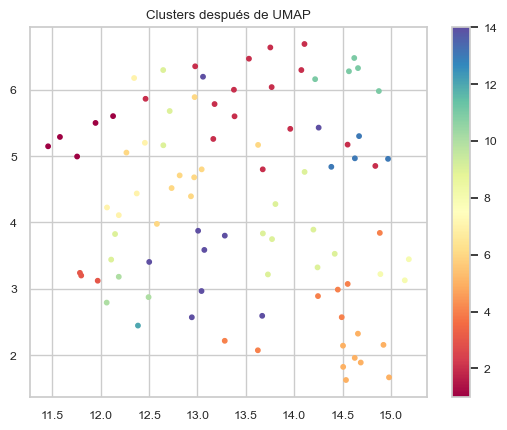

Silhouette Score: 0.063
Calinski-Harabasz Score: 3.549


In [19]:
df_info_reis_pregs = clusterize_dx_questions(rei_id, period)

# Comparar con el ground truth

In [20]:
df_real = pd.read_excel('./ZBE-es.xlsx')
# Limpiar nombres de columnas
df_real.columns = df_real.columns.str.strip().str.replace(r"\s+", " ", regex=True)
# Eliminar espacios al principio y al final de las celdas de texto
df_real = df_real.map(lambda x: x.strip() if isinstance(x, str) else x)
df_real = df_real.dropna(axis=1, how='any')

In [21]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

cols = ['JB', 'LF', 'KM1', 'NR1', 'MB']

In [22]:
labels_pred = df_info_reis_pregs['cluster']
df = df_real.loc[df_info_reis_pregs.index]

# verificamos que las preguntas sean las mismas
comparison = df['Question'] == df_info_reis_pregs['pregunta']
print(f"Total iguales: {comparison.sum()} / {len(comparison)}")

Total iguales: 90 / 90


In [23]:
resultados = []
for col in cols:
    labels_true = df[col]
    
    # Métricas
    ari = metrics.adjusted_rand_score(labels_true, labels_pred)
    nmi = metrics.normalized_mutual_info_score(labels_true, labels_pred)
    purity = purity_score(labels_true, labels_pred)  # Usar la función definida anteriormente
    hom = metrics.homogeneity_score(labels_true, labels_pred)
    com = metrics.completeness_score(labels_true, labels_pred)
    vm = metrics.v_measure_score(labels_true, labels_pred)

    
    resultados.append({
        'Categorización': col,
        'Adjusted Rand Index (ARI)': ari,
        'Normalized Mutual Info (NMI)': nmi,
        'Pureza': purity,
        'Homogeneity': hom,
        'Completeness': com,
        'V-measure': vm
    })

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

  Categorización  Adjusted Rand Index (ARI)  Normalized Mutual Info (NMI)  \
0             JB                   0.149431                      0.447364   
1             LF                   0.025005                      0.409362   
2            KM1                   0.098549                      0.403175   
3            NR1                   0.175984                      0.481706   
4             MB                   0.174513                      0.446871   

     Pureza  Homogeneity  Completeness  V-measure  
0  0.555556     0.492550      0.409772   0.447364  
1  0.466667     0.426233      0.393775   0.409362  
2  0.500000     0.449568      0.365460   0.403175  
3  0.600000     0.527757      0.443047   0.481706  
4  0.633333     0.535355      0.383487   0.446871  


# Imprimir heatmaps

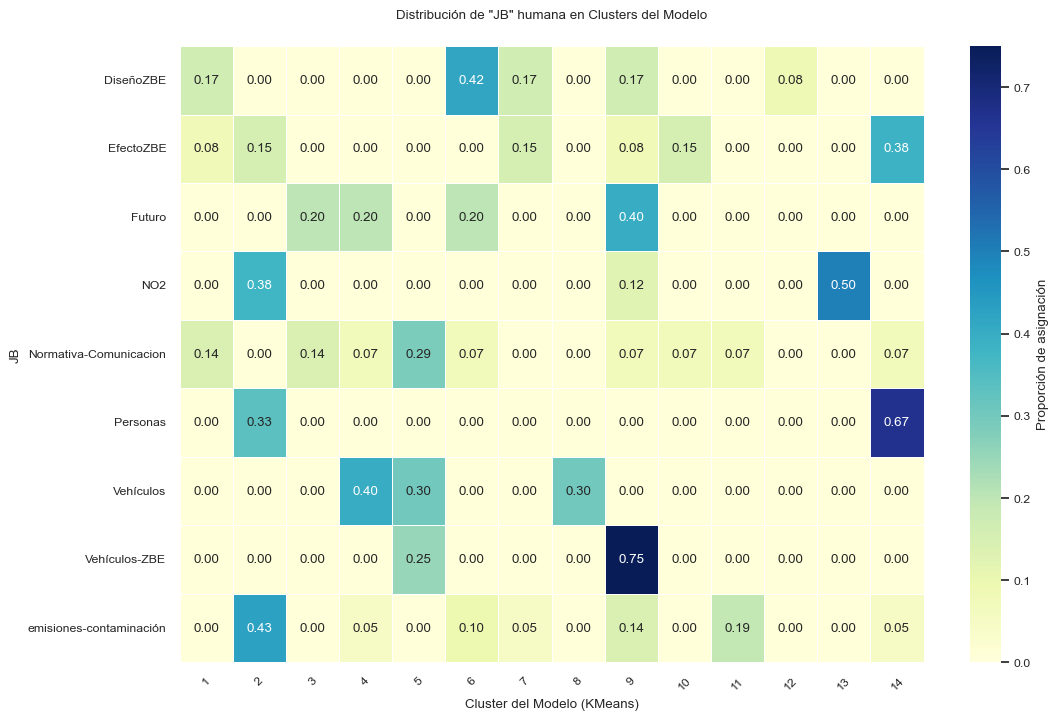

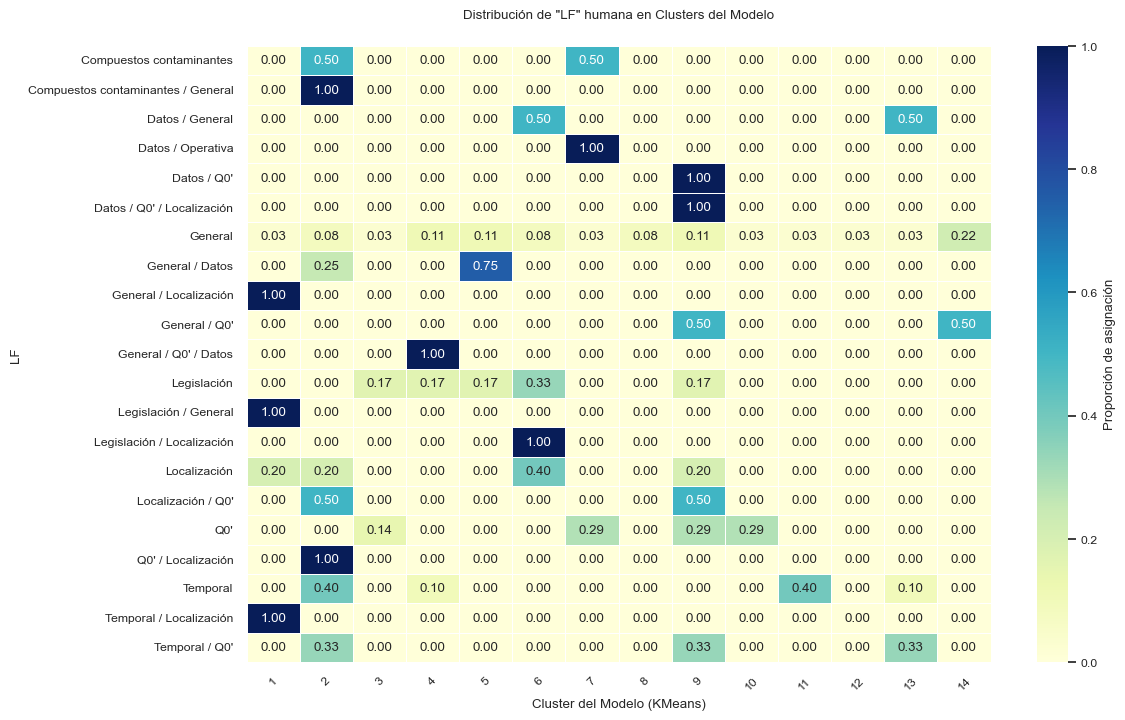

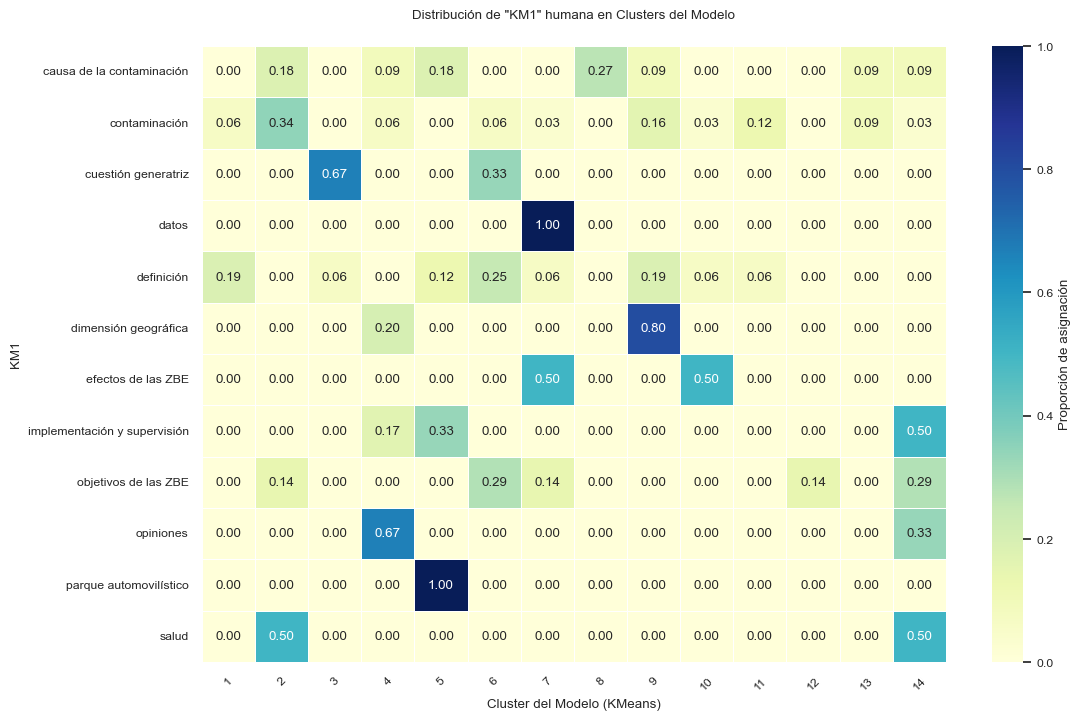

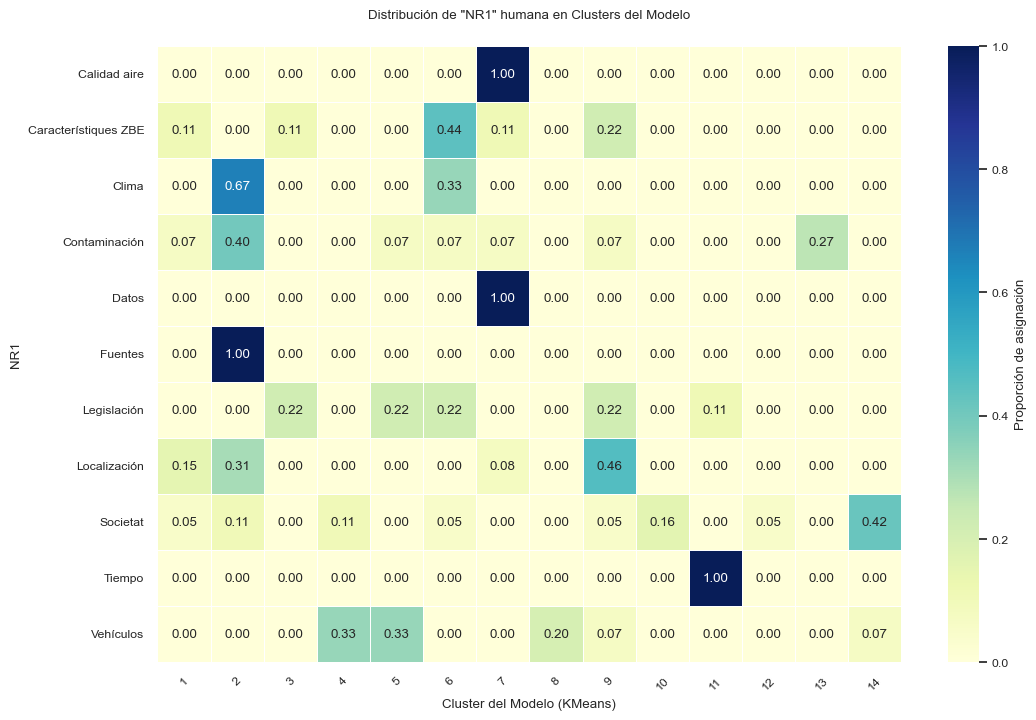

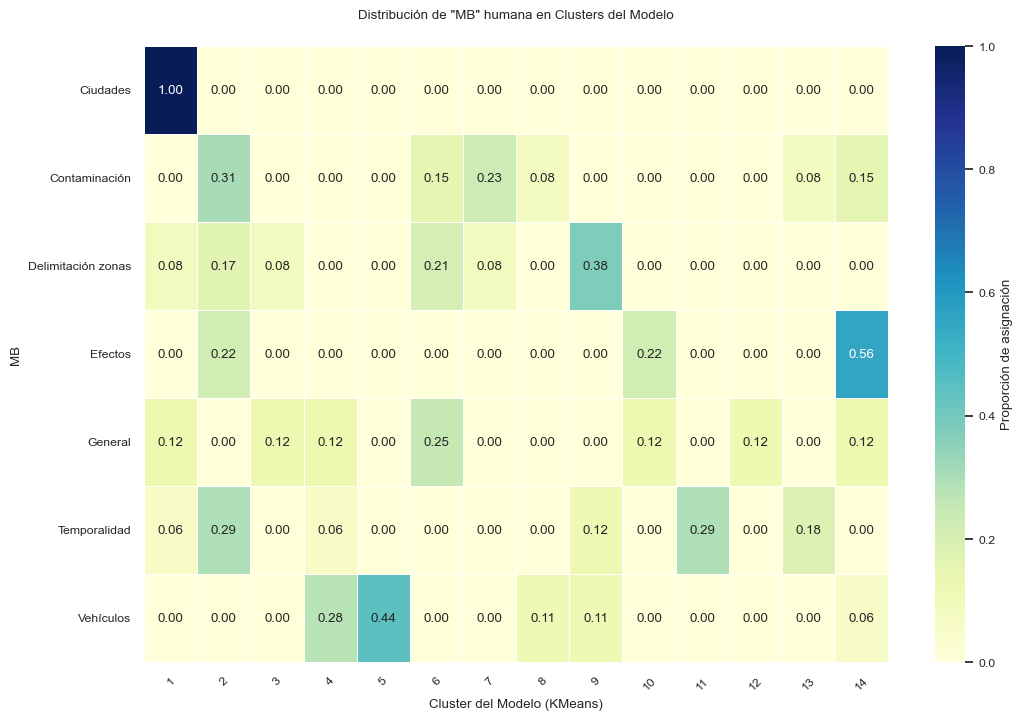

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar estilo de los gráficos
sns.set(style="whitegrid", font_scale=0.8)

# Crear un heatmap por cada categorización humana
for col in cols:
    # Matriz de contingencia: frecuencias cruzadas entre categorías humanas y clusters del modelo
    contingency_matrix = pd.crosstab(df[col], labels_pred, normalize='index')
    
    # Configurar el tamaño del heatmap
    plt.figure(figsize=(12, 8))
    
    # Heatmap con anotaciones
    ax = sns.heatmap(
        contingency_matrix, 
        annot=True, 
        fmt=".2f",  # 2 decimales
        cmap="YlGnBu",  # Mapa de colores
        linewidths=0.5,
        cbar_kws={'label': 'Proporción de asignación'}
    )
    
    # Ajustes de título y ejes
    plt.title(f'Distribución de "{col}" humana en Clusters del Modelo', pad=20)
    plt.xlabel('Cluster del Modelo (KMeans)')
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # Mostrar el gráfico
    plt.show()

In [25]:
df[df['JB'] == 'NO2']['Question']

3                                                   ¿Qué efectos tiene la acumulación de NO2 en estas zonas?
16                                        ¿Cuáles son los factores de los que dependen las emisiones de NO2?
18                                              ¿Cómo varía la emisión de NO2 a medida que avanza el tiempo?
20                                                      Con el tiempo, ¿las emisiones de NO2 han disminuido?
22                                                           ¿En qué altitus encontramos más emisión de NO2?
24                                              ¿Varían las emisiones de NO2 según la vegetación de la zona?
27                            Nos gustaría observar cómo varía la emisión de NO2 dependen de varios factores
46    ¿Es el dióxido de nitrógeno un indicador de referencia general y real de toda la combinación del aire?
Name: Question, dtype: object

In [26]:
df_info_reis_pregs[df_info_reis_pregs['cluster'] == 2]

,pregunta,grupo,lider_name,votos,cluster
3,¿Qué efectos tiene la acumulación de NO2 en estas zonas?,Desconocido,Desconocido,1,2
9,¿En qué época del año existen más emisiones?,"Desconocido,Desconocido",Desconocido,2,2
12,¿Qué grupos de personas son las más afectadas por la contaminación atmosférica?,Desconocido,Desconocido,1,2
21,¿Cuáles son las zonas de Cataluña en las que se producen más emisiones?,Desconocido,Desconocido,1,2
22,¿En qué altitus encontramos más emisión de NO2?,Desconocido,Desconocido,1,2
46,¿Es el dióxido de nitrógeno un indicador de referencia general y real de toda la combinación del aire?,Desconocido,Desconocido,1,2
59,¿Cuáles son las principales causas que provocan la contaminación?,Desconocido,Desconocido,1,2
60,¿Qué zonas son las que encontramos con mayor contaminación?,Desconocido,Desconocido,1,2
67,¿En qué época del año existe una mayor contaminación del aire?,Desconocido,Desconocido,1,2
68,"¿Cuándo hay más contaminación, en fin de semana o en días laborables?",Desconocido,Desconocido,1,2
